In [3]:
# using libraries
cd(@__DIR__)
using Pkg; Pkg.activate("."); Pkg.instantiate()
using Lux
using ComponentArrays
using LineSearches
using LuxAMDGPU
using LuxCUDA
using OrdinaryDiffEq
using Optimization
using OptimizationOptimJL
using Printf
using Random 
using SciMLSensitivity
using Plots

CUDA.allowscalar(false)

  Activating new project at `~/Library/CloudStorage/Dropbox/ANN_BBH/iGW_jl/Extreme_Mass_Ratio`


In [2]:
# necessary julia files
include("models.jl")
include("utils.jl")

compute_waveform (generic function with 2 methods)

In [3]:
# parameters of the model extreme mass ratio
mass_ratio = 0.0         
u0 = Float64[π, 0.0]     #χ,ϕ
datasize = 250           
tspan = (0.0f0, 6.0f4)   
tsteps = range(tspan[1], tspan[2]; length=datasize)  
dt_data = tsteps[2] - tsteps[1]
dt = 100.0
const ode_model_params = [100.0, 1.0, 0.5]; # p, M, e

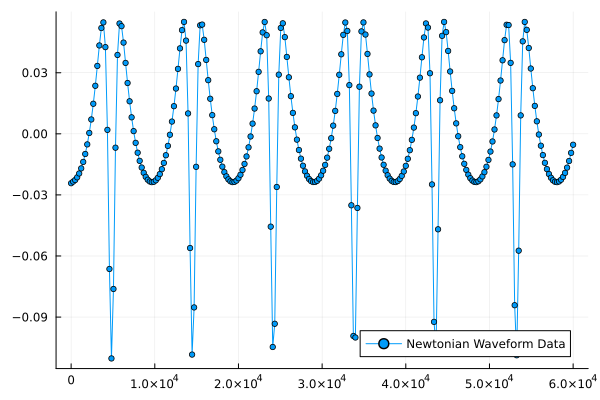

In [4]:
# solving the newtonian model
prob = ODEProblem(NewtonianOrbitModel, u0, tspan, ode_model_params)
soln = Array(solve(prob, RK4(); saveat=tsteps, dt, adaptive=false))
waveform = first(compute_waveform(dt_data, soln, mass_ratio, ode_model_params))

# ploting using Plots.plot
Plots.plot(tsteps, waveform, linewidth = 1, marker=:circle, markersize = 3, label = "Newtonian Waveform Data")

# ploting using cairo
#begin
#    fig = Figure()
#    ax = CairoMakie.Axis(fig[1, 1]; xlabel="Time", ylabel="Waveform")
#    l = lines!(ax, tsteps, waveform; linewidth=1, alpha=0.75)
#    s = scatter!(ax, tsteps, waveform; marker=:circle, markersize=8, alpha=0.5
#    axislegend(ax, [[l, s]], ["Newtonian Waveform Data"])
#    fig
#end

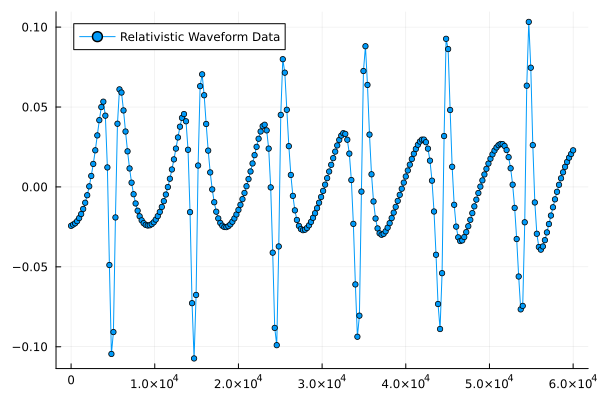

In [5]:
# solving the relativistic model
prob = ODEProblem(RelativisticOrbitModel, u0, tspan, ode_model_params)
soln = Array(solve(prob, RK4(); saveat=tsteps, dt, adaptive=false))
waveform = first(compute_waveform(dt_data, soln, mass_ratio, ode_model_params))

# ploting using Plots.plot
Plots.plot(tsteps, waveform, linewidth = 1, marker=:circle, markersize = 3, label = "Relativistic Waveform Data")

# ploting using cairo
#begin
#    fig = Figure()
#    ax = CairoMakie.Axis(fig[1, 1]; xlabel="Time", ylabel="Waveform")
#    l = lines!(ax, tsteps, waveform; linewidth=1, alpha=0.75)
#    s = scatter!(ax, tsteps, waveform; marker=:circle, markersize=8, alpha=0.5)
#    axislegend(ax, [[l, s]], ["Relativistic Waveform Data"])
#    fig
#end

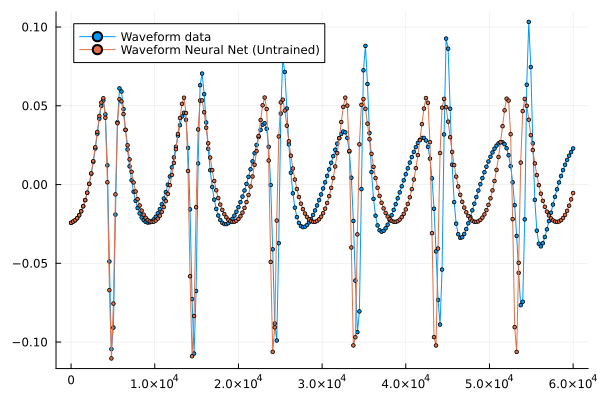

In [6]:
# definition of the neural network
nn = Chain(Base.Fix1(broadcast, cos),
    Dense(1 => 32, cos; init_weight=truncated_normal(; std=1e-4)),
    Dense(32 => 32, cos; init_weight=truncated_normal(; std=1e-4)),
    Dense(32 => 2; init_weight=truncated_normal(; std=1e-4)))
#  setup a specific random number generator (RNG) from the Xoshiro generator
ps, st = Lux.setup(Xoshiro(), nn)

params = ComponentArray{Float64}(ps)
nn_model = StatefulLuxLayer(nn, st)

# solving using neural networks without train
prob_nn = ODEProblem(ODE_model, u0, tspan, params)
soln_nn = Array(solve(prob_nn, RK4(); u0, p=params, saveat=tsteps, dt, adaptive=false))
waveform_nn = first(compute_waveform(dt_data, soln_nn, mass_ratio, ode_model_params))


# ploting using Plots.plot
Plots.plot(tsteps, waveform, linewidth = 1, marker=:circle, markersize = 2, label = "Waveform data")
Plots.plot!(tsteps, waveform_nn, linewidth = 1, marker=:circle, markersize = 2, label = "Waveform Neural Net (Untrained)")

# ploting using cairo
#begin
#    fig = Figure()
#    ax = CairoMakie.Axis(fig[1, 1]; xlabel="Time", ylabel="Waveform")
#    l1 = lines!(ax, tsteps, waveform; linewidth=1, alpha=0.5)
#    s1 = scatter!(ax, tsteps, waveform; marker=:circle, markersize=2, alpha=0.5, strokewidth=1)
#    l2 = lines!(ax, tsteps, waveform_nn; linewidth=1, alpha=0.5)
#    s2 = scatter!(ax, tsteps, waveform_nn; marker=:circle, markersize=2, alpha=0.5, strokewidth=1)
#    axislegend(ax, [[l1, s1], [l2, s2]],["Waveform Data", "Waveform Neural Net (Untrained)"]; position=:lb)
#    fig
#end

In [7]:
# defining the loss function
function loss(θ)
    pred = Array(solve(prob_nn, RK4(); u0, p=θ, saveat=tsteps, dt, adaptive=false))
    pred_waveform = first(compute_waveform(dt_data, pred, mass_ratio, ode_model_params))
    loss = sum(abs2, waveform .- pred_waveform)
    return loss, pred_waveform
end

loss(params)

const losses = Float64[]

function callback(θ, l, pred_waveform)
    push!(losses, l)
    @printf "Training %10s Iteration: %5d %10s Loss: %.10f\n" "" length(losses) "" l
    return false
end

callback (generic function with 1 method)

In [8]:
# training the neural network
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, params)
res = Optimization.solve(optprob, BFGS(; initial_stepnorm=0.01, linesearch=LineSearches.BackTracking());callback, maxiters=1000)

Training            Iteration:     1            Loss: 0.1876753035
Training            Iteration:     2            Loss: 0.0699863641
Training            Iteration:     3            Loss: 0.0421455952
Training            Iteration:     4            Loss: 0.0090114422
Training            Iteration:     5            Loss: 0.0002894202
Training            Iteration:     6            Loss: 0.0002082658
Training            Iteration:     7            Loss: 0.0002046957
Training            Iteration:     8            Loss: 0.0002046730
Training            Iteration:     9            Loss: 0.0002046729
Training            Iteration:    10            Loss: 0.0002046729
Training            Iteration:    11            Loss: 0.0002046729
Training            Iteration:    12            Loss: 0.0002046729


retcode: Success
u: ComponentVector{Float64}(layer_1 = Float64[], layer_2 = (weight = [-6.56667325528616e-5; -3.4722067994067937e-6; … ; 3.2682637538438874e-5; 0.0001516433840151292;;], bias = [-7.381671427737915e-17; -9.608708398046045e-18; … ; 9.909980497774081e-17; 6.879614518178228e-17;;]), layer_3 = (weight = [1.3590398049234204e-5 5.748189749395635e-5 … -0.00012987212296026502 5.543562172647881e-5; -5.930478909535913e-5 -6.527598197240645e-5 … -5.221920156653036e-7 -0.00017586345820120306; … ; 0.00017151945638044623 9.678092890691979e-5 … 0.00014809053816872646 9.877537802832388e-5; 0.00012562303726816045 0.00012384582641323944 … -3.698555684160631e-5 0.0001450625624719215], bias = [-2.6969417075550344e-9; -4.43578133623841e-9; … ; 1.0374425261848133e-9; 3.0178788482114597e-9;;]), layer_4 = (weight = [-0.0006458249718084864 -0.0006302508841881574 … -0.0007860462602324998 -0.0007358572978933355; 0.0004200387540425952 4.321985191594162e-5 … 0.00035346862468933955 0.0001408055996064

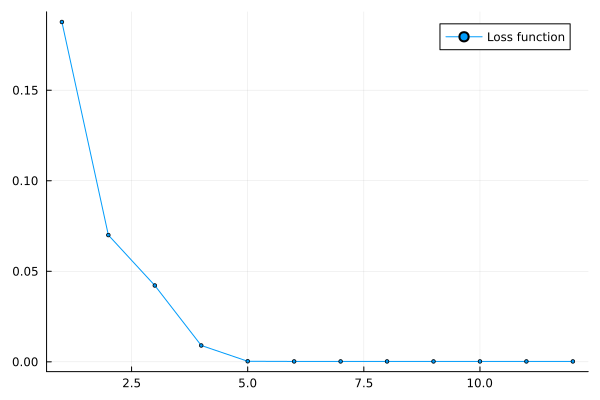

In [9]:
# ploting the loss function using Plots.plot
Plots.plot(1:length(losses), losses, linewidth = 1, marker=:circle, markersize = 2, label = "Loss function")

# ploting using cairo
#begin
#    fig = Figure()
#    ax = CairoMakie.Axis(fig[1, 1]; xlabel="Iteration", ylabel="Loss")
#    lines!(ax, losses; linewidth=3, alpha=0.5)
#    scatter!(ax, 1:length(losses), losses; marker=:circle, markersize=2, strokewidth=2)
#    fig
#end

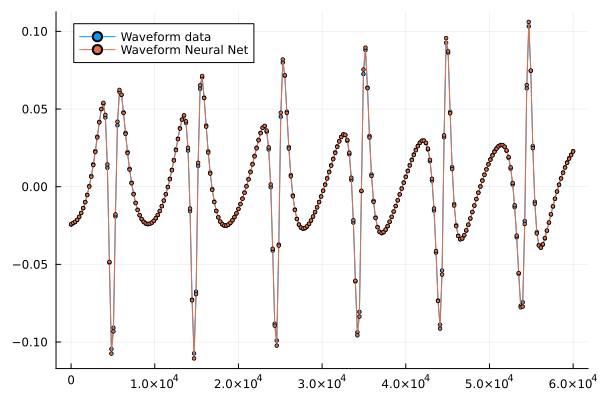

In [10]:
# ploting the data waveform and the neural network waveform
prob_nn = ODEProblem(ODE_model, u0, tspan, res.u)
soln_nn = Array(solve(prob_nn, RK4(); u0, p=res.u, saveat=tsteps, dt, adaptive=false))
waveform_nn_trained = first(compute_waveform(dt_data, soln_nn, mass_ratio, ode_model_params))

Plots.plot(tsteps, waveform, linewidth = 1, marker=:circle, markersize = 2, label = "Waveform data")
Plots.plot!(tsteps, waveform_nn_trained, linewidth = 1, marker=:circle, markersize = 2, label = "Waveform Neural Net")

# ploting using cairo
#begin
#    fig = Figure()
#    ax = CairoMakie.Axis(fig[1, 1]; xlabel="Time", ylabel="Waveform")
#    l1 = lines!(ax, tsteps, waveform; linewidth=2, alpha=0.5)
#    s1 = scatter!(ax, tsteps, waveform; marker=:circle, alpha=0.5, strokewidth=2, markersize=2)
#    l2 = lines!(ax, tsteps, waveform_nn_trained; linewidth=2, alpha=0.55)
#    s2 = scatter!(ax, tsteps, waveform_nn_trained; marker=:circle, alpha=0.5, strokewidth=2, markersize=2)
#    axislegend(ax, [[l1, s1], [l2, s2]],["Waveform Data", "Waveform Neural Net"];position=:lb)
#    fig
#end

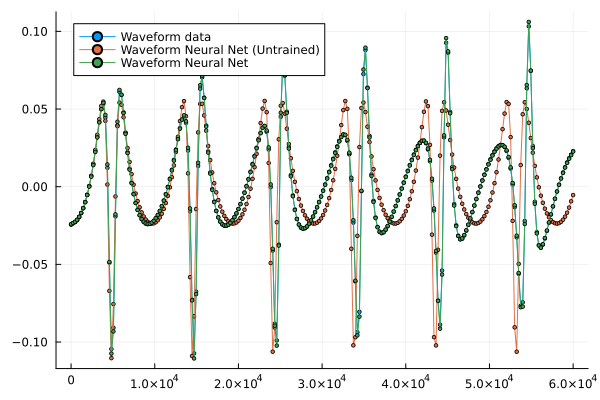

In [11]:
# ploting the data waveform, the neural network without training and the neural network waveform
prob_nn = ODEProblem(ODE_model, u0, tspan, res.u)
soln_nn = Array(solve(prob_nn, RK4(); u0, p=res.u, saveat=tsteps, dt, adaptive=false))
waveform_nn_trained = first(compute_waveform(dt_data, soln_nn, mass_ratio, ode_model_params))

# using Plots.plot
Plots.plot(tsteps, waveform, linewidth = 1, marker=:circle, markersize = 2, label = "Waveform data")
Plots.plot!(tsteps, waveform_nn, linewidth = 1, marker=:circle, markersize = 2, label = "Waveform Neural Net (Untrained)")
Plots.plot!(tsteps, waveform_nn_trained, linewidth = 1, marker=:circle, markersize = 2, label = "Waveform Neural Net")

# ploting using cairo
#begin
#    fig = Figure()
#    ax = CairoMakie.Axis(fig[1, 1]; xlabel="Time", ylabel="Waveform")
#    l1 = lines!(ax, tsteps, waveform; linewidth=2, alpha=0.5)
#    s1 = scatter!(ax, tsteps, waveform; marker=:circle, alpha=0.5, strokewidth=2, markersize=2)
#    l2 = lines!(ax, tsteps, waveform_nn; linewidth=2, alpha=0.5)
#    s2 = scatter!(ax, tsteps, waveform_nn; marker=:circle, alpha=0.5, strokewidth=2, markersize=2)
#    l3 = lines!(ax, tsteps, waveform_nn_trained; linewidth=2, alpha=0.5)
#    s3 = scatter!(ax, tsteps, waveform_nn_trained; marker=:circle, alpha=0.5, strokewidth=2, markersize=2)
#    axislegend(ax, [[l1, s1], [l2, s2], [l3, s3]],["Waveform Data", "Waveform Neural Net (Untrained)", "Waveform Neural Net"]; position=:lb)
#    fig
#end

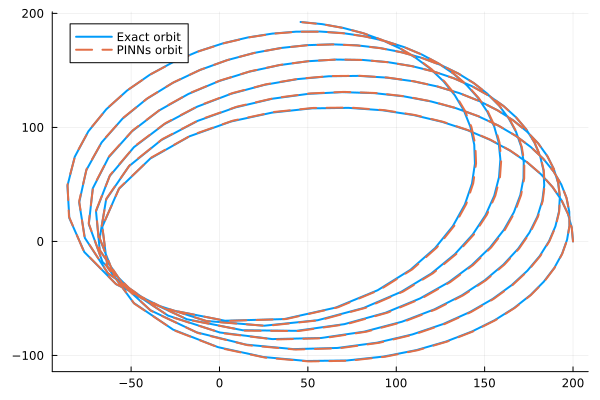

In [12]:
# ploting the orbit
reference_solution = solve(remake(prob, p = ode_model_params, saveat = tsteps, tspan=tspan),RK4(), dt = dt, adaptive=false)
optimized_solution = solve(remake(prob_nn, p = res.minimizer, saveat = tsteps, tspan=tspan),RK4(), dt = dt, adaptive=false)

true_orbit = soln2orbit(reference_solution, ode_model_params)
pred_orbit = soln2orbit(optimized_solution, ode_model_params)

plt = Plots.plot(true_orbit[1,:], true_orbit[2,:], linewidth = 2, label = "Exact orbit")
Plots.plot!(plt, pred_orbit[1,:], pred_orbit[2,:], linestyle = :dash, linewidth = 2, label = "PINNs orbit")

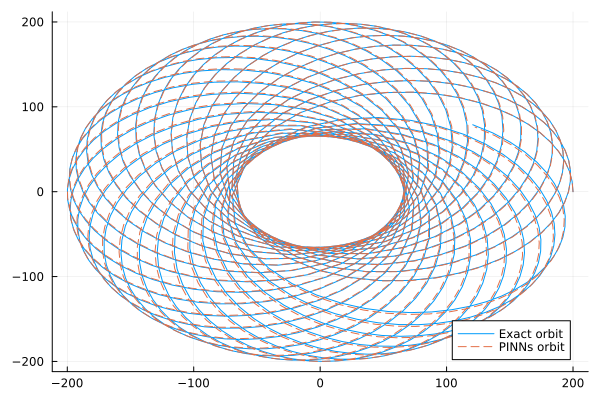

In [13]:
# ploting the orbit extended by factor of 5
factor=5

extended_tspan = (tspan[1], factor*tspan[2])
extended_tsteps = range(tspan[1], factor*tspan[2], length = factor*datasize)

reference_solution = solve(remake(prob, p = ode_model_params, saveat = extended_tsteps, tspan=extended_tspan),RK4(), dt = dt, adaptive=false)
optimized_solution = solve(remake(prob_nn, p = res.minimizer, saveat = extended_tsteps, tspan=extended_tspan),RK4(), dt = dt, adaptive=false)

true_orbit = soln2orbit(reference_solution, ode_model_params)
pred_orbit = soln2orbit(optimized_solution, ode_model_params)

Plots.plot(true_orbit[1,:], true_orbit[2,:], linewidth = 1, label = "Exact orbit")
Plots.plot!(pred_orbit[1,:], pred_orbit[2,:], linestyle = :dash, linewidth = 1, label = "PINNs orbit")

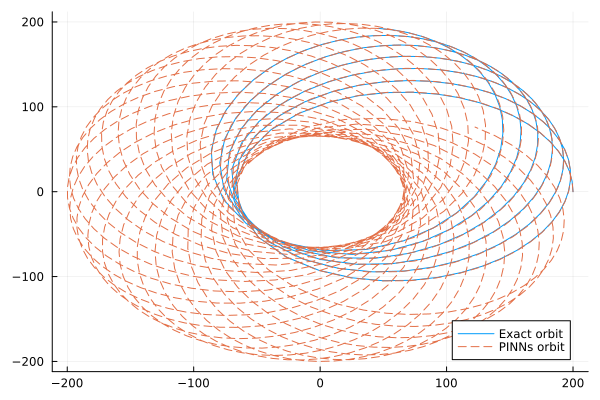

In [14]:
# ploting the entire orbit to see the constrats
extended_tspan = (tspan[1], factor*tspan[2])
extended_tsteps = range(tspan[1], factor*tspan[2], length = factor*datasize)

reference_solution = solve(remake(prob, p = ode_model_params, saveat = tsteps, tspan = tspan),RK4(), dt = dt, adaptive=false)
optimized_solution = solve(remake(prob_nn, p = res.minimizer, saveat = extended_tsteps, tspan=extended_tspan),RK4(), dt = dt, adaptive=false)

true_orbit = soln2orbit(reference_solution, ode_model_params)
pred_orbit = soln2orbit(optimized_solution, ode_model_params)

Plots.plot(true_orbit[1,:], true_orbit[2,:], linewidth = 1, label = "Exact orbit")
Plots.plot!(pred_orbit[1,:], pred_orbit[2,:], linestyle = :dash, linewidth = 1, label = "PINNs orbit")